In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from pandas.plotting import autocorrelation_plot
#from google.cloud import storage

In [64]:
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    # bucket_name = "your-bucket-name"

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)

    for blob in blobs:
        print(blob.name)


In [90]:
buildings=['all_years/Barrows Hall - Electric Demand 2015-12-01 00_00 to 2016-12-01 00_00 15 Minutes.csv',
 'all_years/Soda Hall - Electrical Demand 2016-12-01 00_00 to 2017-12-01 00_00 15 Minutes.csv',
 'all_years/Barrows Hall - Electric Demand 2016-12-01 00_00 to 2017-12-01 00_00 15 Minutes.csv',
 'all_years/Sproul Hall - Electrical Demand 2016-12-01 00_00 to 2017-12-01 00_00 15 Minutes.csv',
 'all_years/Etcheverry Hall - Electrical Demand 2016-12-01 00_00 to 2017-12-01 00_00 15 Minutes.csv',
 'all_years/Latimer Hall - Electrical Demand 2016-12-01 00_00 to 2017-12-01 00_00 15 Minutes.csv',
 'all_years/Barrows Hall - Electric Demand 2017-12-01 00_00 to 2018-12-01 00_00 15 Minutes.csv',
 'all_years/Soda Hall - Electrical Demand 2017-12-01 00_00 to 2018-12-01 00_00 15 Minutes.csv',
 'all_years/Latimer Hall - Electrical Demand 2017-12-01 00_00 to 2018-12-01 00_00 15 Minutes.csv',
 'all_years/Sproul Hall - Electrical Demand 2017-12-01 00_00 to 2018-12-01 00_00 15 Minutes.csv',
 'all_years/Etcheverry Hall - Electrical Demand 2017-12-01 00_00 to 2018-12-01 00_00 15 Minutes.csv',
 'all_years/Barrows Hall - Electric Demand 2018-12-01 00_00 to 2019-12-01 00_00 15 Minutes.csv',
 'all_years/Soda Hall - Electrical Demand 2018-12-01 00_00 to 2019-12-01 00_00 15 Minutes.csv',
 'all_years/Latimer Hall - Electrical Demand 2018-12-01 00_00 to 2019-12-01 00_00 15 Minutes.csv',
 'all_years/Sproul Hall - Electrical Demand 2018-12-01 00_00 to 2019-12-01 00_00 15 Minutes.csv',
 'all_years/Etcheverry Hall - Electrical Demand 2018-12-01 00_00 to 2019-12-01 00_00 15 Minutes.csv']

barrows = pd.concat([pd.read_csv(s) for s in buildings if 'Barrows Hall' in s])
etcheverry = pd.concat([pd.read_csv(s) for s in buildings if 'Etcheverry Hall' in s])
latimer = pd.concat([pd.read_csv(s) for s in buildings if 'Latimer Hall' in s])
soda = pd.concat([pd.read_csv(s) for s in buildings if 'Soda Hall' in s])
sproul = pd.concat([pd.read_csv(s) for s in buildings if 'Sproul Hall' in s])

barrows['Building_name'] = 'Barrows Hall'
etcheverry['Building_name'] = 'Etcheverry Hall'
latimer['Building_name'] = 'Latimer Hall'
soda['Building_name'] = 'Soda Hall'
sproul['Building_name'] = 'Sproul Hall'


In [92]:
barrows.head()

,Date,BAR_KWH_Main_Electric (kWh),BAR_PWR_Main_Electric (kW),Building_name
0,2015-12-01 00:00,20.736,82.944,Barrows Hall
1,2015-12-01 00:15,39.744,76.032,Barrows Hall
2,2015-12-01 00:30,60.480,82.944,Barrows Hall
3,2015-12-01 00:45,79.488,76.032,Barrows Hall
4,2015-12-01 01:00,98.496,76.032,Barrows Hall


In [102]:
all_years = barrows.merge(etcheverry, on=['Building_name', 'Date'], how='outer')
all_years = all_years.merge(latimer, on=['Building_name', 'Date'], how='outer')
all_years = all_years.merge(soda, on=['Building_name', 'Date'], how='outer')
all_years = all_years.merge(sproul, on=['Building_name', 'Date'], how='outer')
all_years.rename(columns={'Date': 'Date_Time'}, inplace=True)
all_years = all_years[['Date_Time', 'Building_name', 'BAR_KWH_Main_Electric (kWh)']]

In [105]:
all_years['Date_Time'].max()

'2019-11-30 23:45'

In [106]:
all_years['Date_Time'].min()

'2015-12-01 00:00'

In [ ]:
all_years.to_csv('5buildings_electric.csv')

In [139]:
# TODO: convert to adjusted kwh???
all_years.rename(columns={'BAR_KWH_Main_Electric (kWh)':'Adjusted_KWH'}, inplace=True)

In [140]:
all_years.head()

,Date_Time,Building_name,Adjusted_KWH
0,2015-12-01 00:00,Barrows Hall,20.736
1,2015-12-01 00:15,Barrows Hall,39.744
2,2015-12-01 00:30,Barrows Hall,60.480
3,2015-12-01 00:45,Barrows Hall,79.488
4,2015-12-01 01:00,Barrows Hall,98.496


In [54]:
load_16, load_17, load_18, load_19 = [pd.read_csv('LBNL_201'+str(x)+'.csv') for x in [6,7,8,9]]

In [50]:
def create_datetime_col(df):
    dates = df['Date'] + ' ' + df['Time']
    df['Date_Time'] = pd.to_datetime(dates, format='%m/%d/%Y %H:%M')
    return df

In [51]:
loads = [load_16, load_17, load_18, load_19]
load_16, load_17, load_18, load_19 = [create_datetime_col(load) for load in loads]

In [52]:
cols_to_drop = ['relative_humidity_set_1', 'dew_point_temperature_set_1d', 'air_temp_set_Avg', 'Date', 'Time']
load_16.drop(columns=cols_to_drop, inplace=True)
load_16.rename(columns={'Station_ID': 'Building_name'}, inplace=True)
load_17.drop(columns=cols_to_drop, inplace=True)
load_17.rename(columns={'Station_ID': 'Building_name'}, inplace=True)
load_18.drop(columns=cols_to_drop, inplace=True)
load_18.rename(columns={'Station_ID': 'Building_name'}, inplace=True)
load_19.drop(columns=cols_to_drop, inplace=True)
load_19.rename(columns={'Station_ID': 'Building_name'}, inplace=True)

In [57]:
load_16.head()

,Station_ID,relative_humidity_set_1,dew_point_temperature_set_1d,air_temp_set_Avg,Date,Time
0,LBNL1,44.21,-1.22,10.990,12/1/2015,23:00
1,LBNL1,43.68,-1.21,11.105,12/1/2015,23:15
2,LBNL1,44.44,-1.02,10.975,12/1/2015,23:30
3,LBNL1,44.91,-0.94,10.885,12/1/2015,23:45
4,LBNL1,42.26,-1.18,11.510,12/2/2015,0:00


In [133]:
df = all_years

In [141]:
#null values in main dataset for weather
print("Null values: "+str(df.Adjusted_KWH.isna().sum()))

Null values: 420444


In [143]:
# Filling NA values
df['Adjusted_KWH']=df['Adjusted_KWH'].fillna(method='bfill')
print("Null values: "+str(df.Adjusted_KWH.isna().sum()))

Null values: 420432


In [144]:
#Filter required buildings alone
b=['Barrows Hall','Etcheverry Hall','Latimer Hall','Soda Hall','Sproul Hall']
df_filt=df[df['Building_name'].isin(b)]

In [145]:
#Key set to a specific building for analysis
key='Barrows Hall'

In [146]:
#taking a sample set for load
df_e=df_filt[['Date_Time','Adjusted_KWH','Building_name']]

In [147]:
!pip install pmdarima

You should consider upgrading via the '/home/yana/my_project_dir/my_project_env/bin/python -m pip install --upgrade pip' command.


# LBNL ELECTRIC ANALYSIS: 

In [148]:
# Reading the individual files
LBNL_2019=all_years[all_years['Date_Time'].dt.year > 2018]


AttributeError: Can only use .dt accessor with datetimelike values

In [111]:
# combining date and time and converting to Datetime object 
LBNL_2019['Date_Time']=pd.to_datetime(LBNL_2019.Date+str(' ')+LBNL_2019.Time)
LBNL_2018['Date_Time']=pd.to_datetime(LBNL_2018.Date+str(' ')+LBNL_2018.Time)
LBNL_2017['Date_Time']=pd.to_datetime(LBNL_2017.Date+str(' ')+LBNL_2017.Time)
LBNL_2016['Date_Time']=pd.to_datetime(LBNL_2016.Date+str(' ')+LBNL_2016.Time)

In [112]:
# See the Dataframe head
LBNL_2016.head()
#LBNL_2017.head()
#LBNL_2018.head()
#LBNL_2019.head()

,Station_ID,relative_humidity_set_1,dew_point_temperature_set_1d,air_temp_set_Avg,Date,Time,Date_Time
0,LBNL1,44.21,-1.22,10.990,12/1/2015,23:00,2015-12-01 23:00:00
1,LBNL1,43.68,-1.21,11.105,12/1/2015,23:15,2015-12-01 23:15:00
2,LBNL1,44.44,-1.02,10.975,12/1/2015,23:30,2015-12-01 23:30:00
3,LBNL1,44.91,-0.94,10.885,12/1/2015,23:45,2015-12-01 23:45:00
4,LBNL1,42.26,-1.18,11.510,12/2/2015,0:00,2015-12-02 00:00:00


In [113]:
#keeping only Avg temperature column
df_19=LBNL_2019.drop(columns=['Date', 'Time','Station_ID','relative_humidity_set_1','dew_point_temperature_set_1d'])
df_18=LBNL_2018.drop(columns=['Date', 'Time','Station_ID','relative_humidity_set_1','dew_point_temperature_set_1d'])
df_17=LBNL_2017.drop(columns=['Date', 'Time','Station_ID','relative_humidity_set_1','dew_point_temperature_set_1d'])
df_16=LBNL_2016.drop(columns=['Date', 'Time','Station_ID','relative_humidity_set_1','dew_point_temperature_set_1d'])

In [114]:
df_19=df_19.rename(columns={'air_temp_set_Avg':'Temp'})
df_18=df_18.rename(columns={'air_temp_set_Avg':'Temp'})
df_17=df_17.rename(columns={'air_temp_set_Avg':'Temp'})
df_16=df_16.rename(columns={'air_temp_set_Avg':'Temp'})

In [115]:
len(df_16.Temp)

34776

In [116]:
len(df_18.Date_Time)

34996

In [117]:
# Leaving dataframe 2019 for testing ARIMA
df_total=pd.concat([df_16,df_17,df_18],axis=0)
df_total.rename(columns={})
df_total['Date_Time']=pd.to_datetime(df_total['Date_Time'])
df_total=df_total.reset_index()
df_total=df_total.drop(columns=['index'])
df_total.head()

,Temp,Date_Time
0,10.990,2015-12-01 23:00:00
1,11.105,2015-12-01 23:15:00
2,10.975,2015-12-01 23:30:00
3,10.885,2015-12-01 23:45:00
4,11.510,2015-12-02 00:00:00


In [118]:
df_total=df_total.set_index('Date_Time')

In [119]:
len(df_total.Temp)

104800

In [120]:
df_total.Temp.isna().sum()

194

In [121]:
df_total.Temp=df_total.Temp.fillna(method='bfill')

In [122]:
df_total.Temp.isna().sum()

0

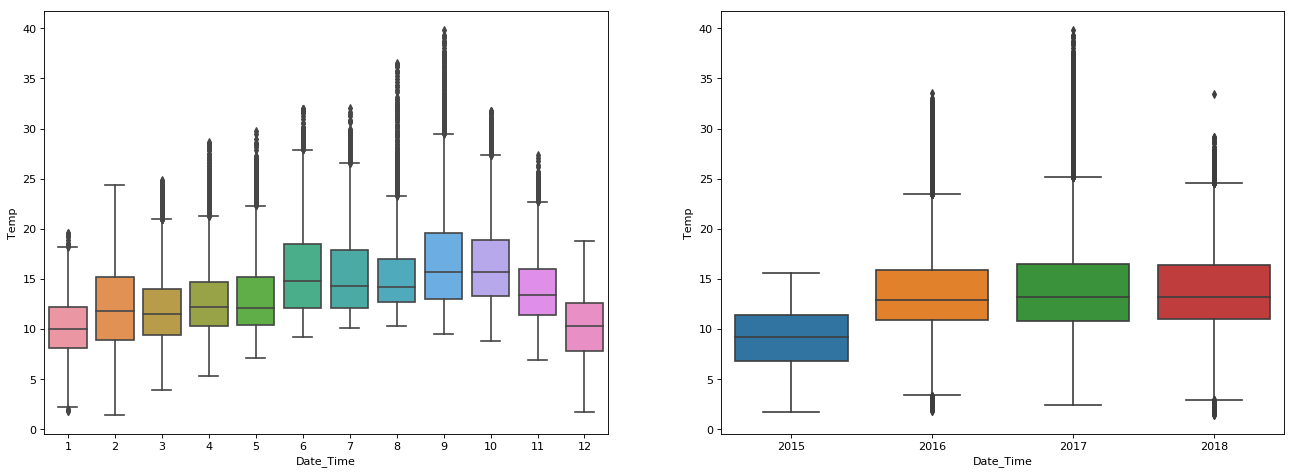

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x=pd.DatetimeIndex(df_total.index).month, y='Temp', data=df_total,ax=axes[0])
sns.boxplot(x=pd.DatetimeIndex(df_total.index).year, y='Temp', data=df_total,ax=axes[1]);

In [124]:
df_total.tail()

,Temp
Date_Time,
2018-11-30 22:00:00,8.980
2018-11-30 22:15:00,8.950
2018-11-30 22:30:00,9.000
2018-11-30 22:45:00,8.985
2018-11-30 23:00:00,9.045


TIME SERIES DECOMPOSITION

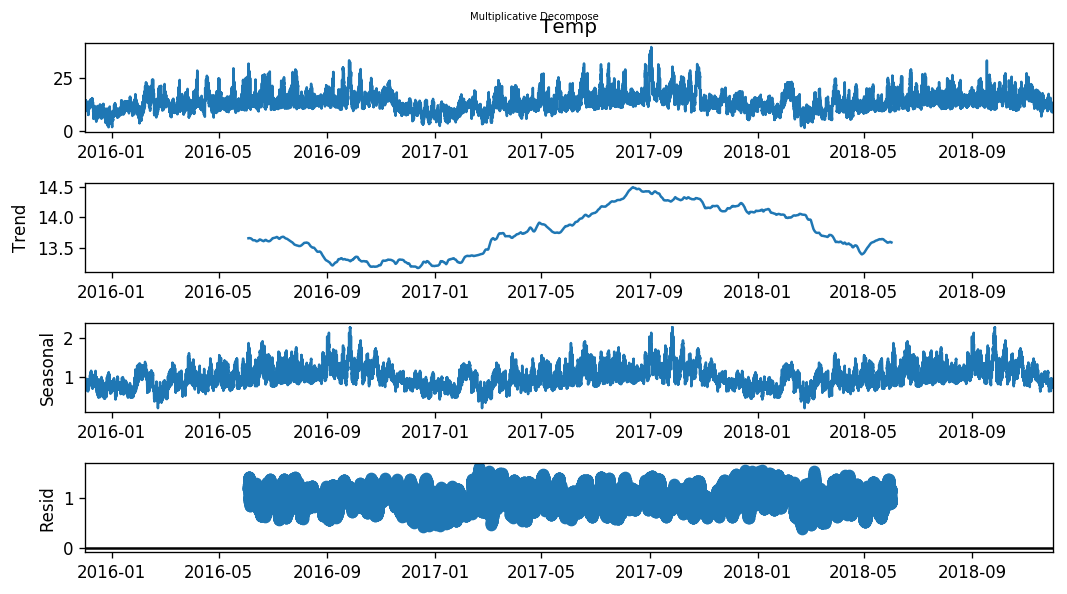

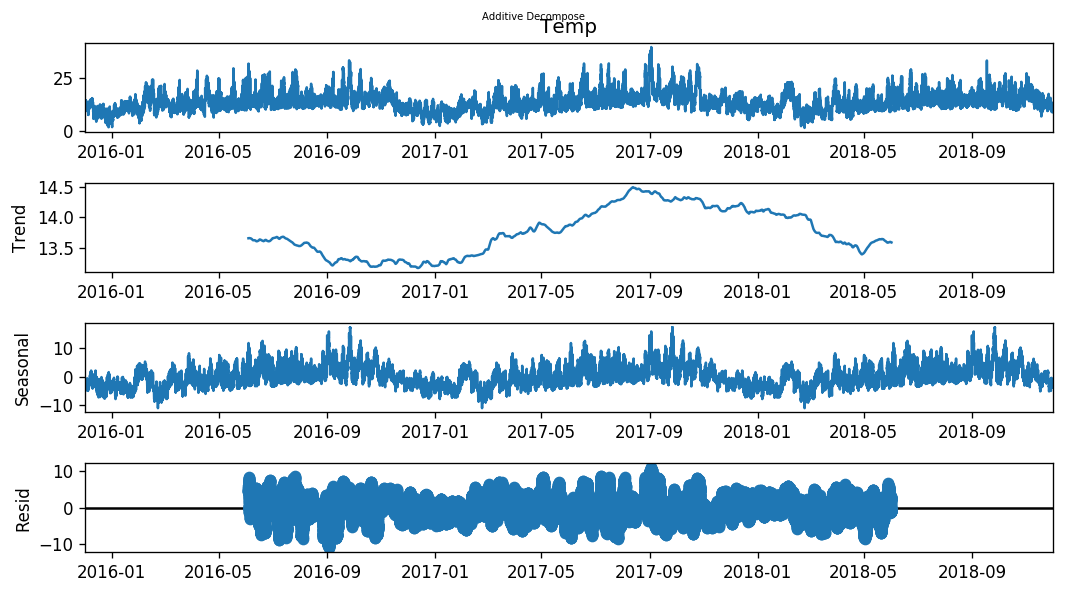

In [128]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_total.Temp, model='multiplicative',period=35000)

# Additive Decomposition
result_add = seasonal_decompose(df_total.Temp, model='additive',period=35000)

# Plot
#plt.rcParams.update({'figure.figsize': (10,10)})
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=6)
result_add.plot().suptitle('Additive Decompose', fontsize=6)
plt.show()

In [26]:
# We choose the additive model as the residuals are more or less randomized without seasonality or trend.
# The numerical output of the trend, seasonal and residual components are stored in the result_mul output itself. 
# Let’s extract them and put it in a dataframe.Actual Values = Product of (Seasonal * Trend * Resid)
df_total_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_total_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_total_reconstructed.head()

,seas,trend,resid,actual_values
Date_Time,,,,
2015-12-01 23:00:00,-3.222988,NaN,NaN,10.990
2015-12-01 23:15:00,-3.552839,NaN,NaN,11.105
2015-12-01 23:30:00,-3.502686,NaN,NaN,10.975
2015-12-01 23:45:00,-3.905026,NaN,NaN,10.885
2015-12-02 00:00:00,-3.877366,NaN,NaN,11.510


Stationarity Check

In [27]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_total.Temp, autolag='AIC')
print('ADF Statistic : %f' % result[0])
print('p-value : %f' % result[1])

ADF Statistic : -9.731277
p-value : 0.000000


so, it is stationary

Seasonality test:

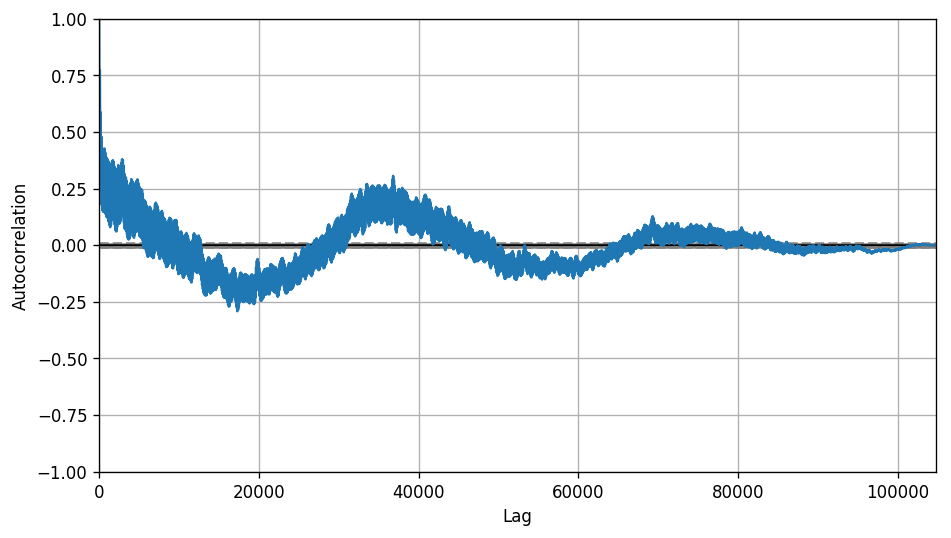

In [28]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df_total.Temp.tolist())

Autocorrelation & Partial Autocorrelation Plots

In [29]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

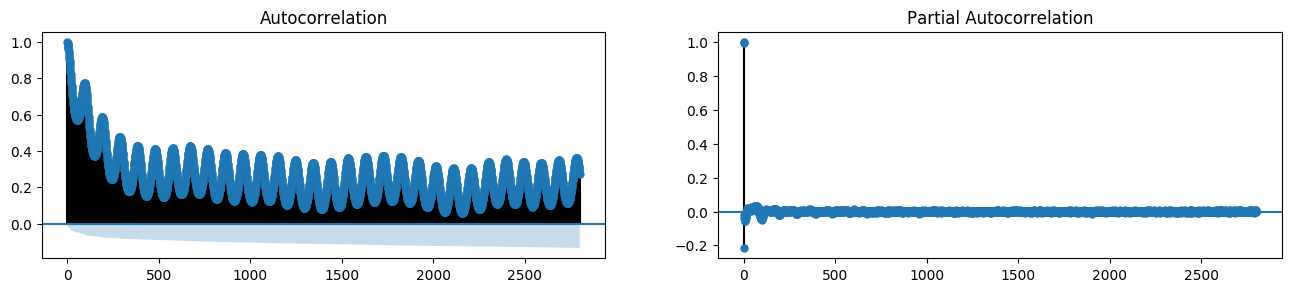

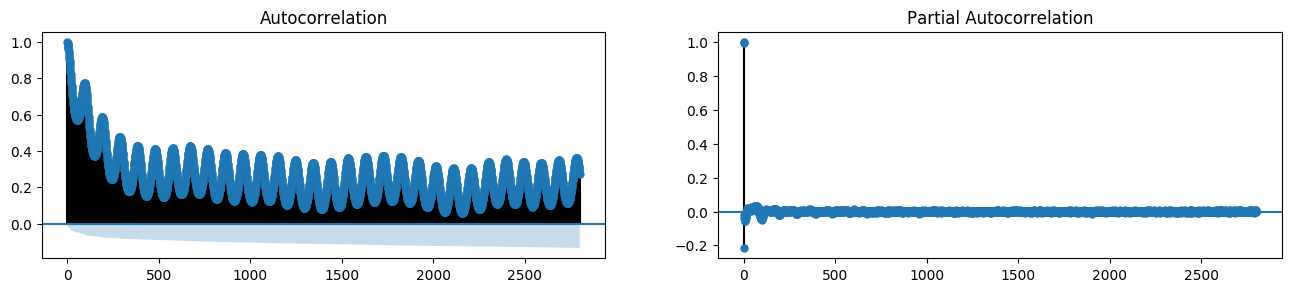

In [30]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_total.Temp.tolist(), lags=2800, ax=axes[0])
plot_pacf(df_total.Temp.tolist(), lags=2800, ax=axes[1])

Lag plots:

Text(0.5, 1.15, 'Lag Plots of Weather \n(Points get wide and scattered with increasing lag -> lesser correlation)\n')

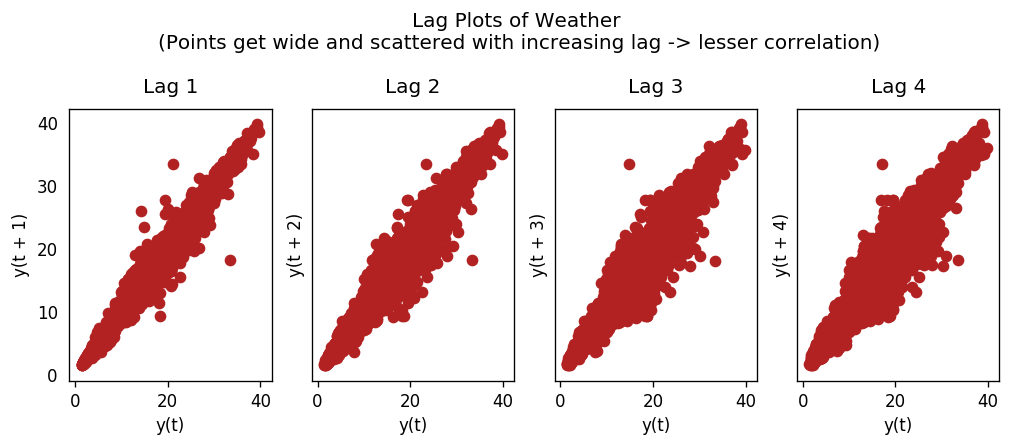

In [31]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=120)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df_total.Temp, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Weather \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

SEASONAL AUTO ARIMA ON WEATHER

In [32]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [33]:
model = pm.auto_arima(df_total.Temp, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=20, max_q=20, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=113160.558, BIC=113198.797, Time=15.141 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=614588.415, BIC=614607.535, Time=2.359 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=117787.657, BIC=117816.336, Time=7.452 seconds
Near non-invertible roots for order (1, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=480443.806, BIC=480472.485, Time=17.077 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=857104.581, BIC=857114.141, Time=1.061 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=112763.985, BIC=112811.784, Time=54.847 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=112823.733, BIC=112861.972, Time=9.540 seconds
Near non-invertible roots for order (2, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the

In [34]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               104800
Model:               SARIMAX(5, 0, 1)   Log Likelihood              -55549.928
Date:                Mon, 04 May 2020   AIC                         111115.855
Time:                        05:56:52   BIC                         111192.334
Sample:                             0   HQIC                        111139.016
                             - 104800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0202      0.001     20.976      0.000       0.018       0.022
ar.L1          2.0039      0.005    370.073      0.000       1.993       2.015
ar.L2         -1.1638      0.007   -178.078      0.0

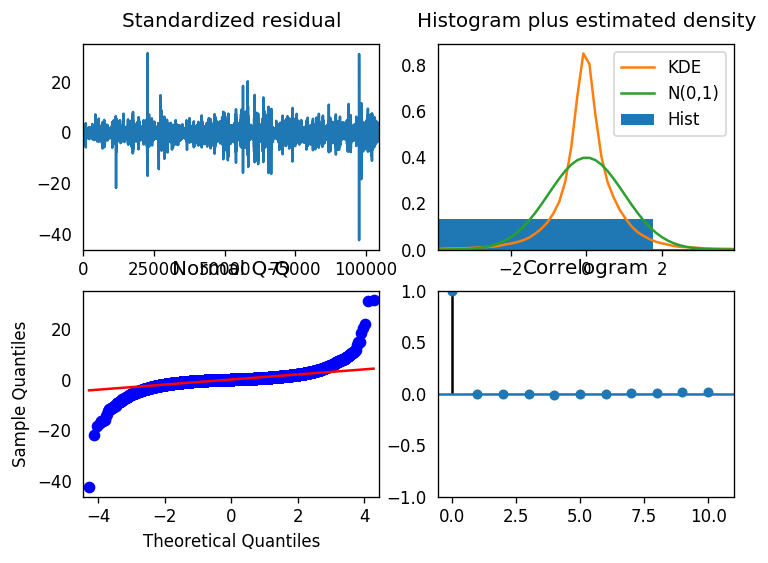

In [35]:
#interpreting the residual plots in ARIMA model
model.plot_diagnostics(figsize=(7,5))
plt.show()

So how to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

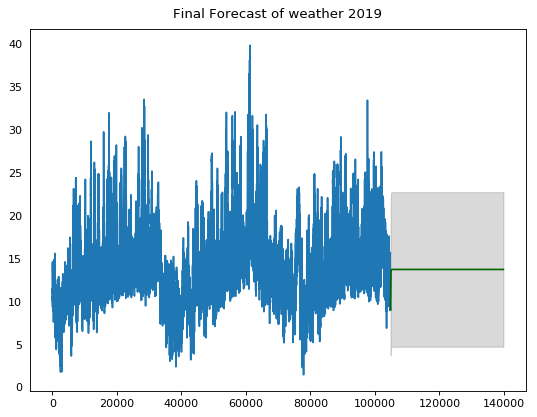

In [49]:
# Forecast
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
n_periods = 35000
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df_total.Temp), len(df_total.Temp)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_total.Temp.tolist())
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of weather 2019")
plt.show()